# Character Detection using Yunet and OpenCV

*Réalisé par Ahmad EL KAAKOUR & Matthieu RANDRIANTSOA*

> Ce Notebook synthétise notre démarche pour exploiter des modèles de fondation dans le cadre de la détection et la reconnaissance de visages. Notre objectif et de permettre de reconnaitre les personnages présents sur la vidéo fournie en entrée.

Les dépendances nécessaires à l'exécution des instructions présentes dans ce projet sont détaillées dans le fichier requirements.txt.

Sont joints à ce Notebook :
- Le module *utils.py* contenant les fonctions utilitaires.
- Le script *YuNet_video_processing.py* qui permet d'appliquer le traitement de reconnaissance de personnage sur une vidéo*.
- Les différentes vidéos résultats.
- Autres fichiers utilisés pour la réalisation du projets.

In [19]:
import mediapipe as mp
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import utils
import face_recognition

from YuNet_video_processing import input_size

## Détection de visage

Pour la détection des visages, nous avons initialement opté pour le modèle pré-entraîné Mediapipe Face Detection, développé par Google. Ce modèle nous permet en quelques lignes de code de détecter les visages dans des images ou des vidéos.

### Importer les images

In [7]:
image1 = cv.imread('images/johnny-english-capture-1.png')
image2 = cv.imread('images/johnny-english-capture-2.png')

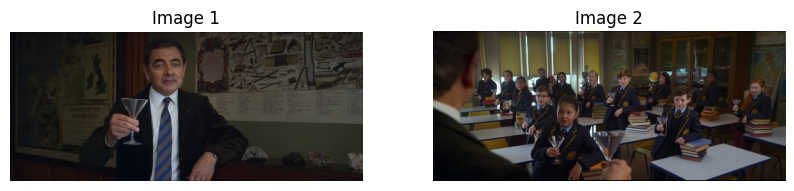

In [9]:
# Convert images from BGR to RGB for Matplotlib
image1_rgb = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2_rgb = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

# Plot the images side by side
plt.rcParams['figure.figsize'] = (10.0, 5.0)  # Adjust figure size
fig, axs = plt.subplots(1, 2)  # Create two subplots

# Display the first image
axs[0].imshow(image1_rgb)
axs[0].axis('off')  # Hide axes
axs[0].set_title("Image 1")

# Display the second image
axs[1].imshow(image2_rgb)
axs[1].axis('off')  # Hide axes
axs[1].set_title("Image 2")

plt.show()

### Initialisation de Mediapipe Face Detection

In [10]:
# Use Mediapipe Face Detection tool

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [11]:
# Minimum detection confidence
min_detection_confidence = 0.9

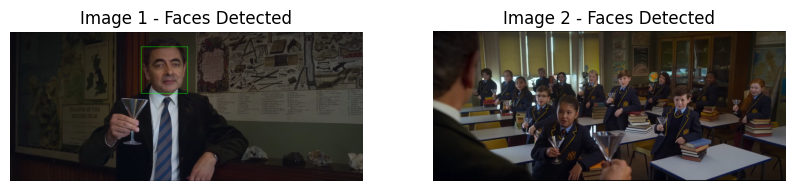

In [12]:
# Perform face detection using MediaPipe
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=min_detection_confidence) as face_detection:
    image1_faces = utils.detect_faces_mediapipe(image1.copy(), face_detection)
    image2_faces = utils.detect_faces_mediapipe(image2.copy(), face_detection)

# Convert images from BGR to RGB for Matplotlib
image1_faces_rgb = cv.cvtColor(image1_faces, cv.COLOR_BGR2RGB)
image2_faces_rgb = cv.cvtColor(image2_faces, cv.COLOR_BGR2RGB)

# Plot the images side by side with rectangles
plt.rcParams['figure.figsize'] = (10.0, 5.0)  # Adjust figure size
fig, axs = plt.subplots(1, 2)  # Create two subplots

# Display the first image with faces detected
axs[0].imshow(image1_faces_rgb)
axs[0].axis('off')  # Hide axes
axs[0].set_title("Image 1 - Faces Detected")

# Display the second image with faces detected
axs[1].imshow(image2_faces_rgb)
axs[1].axis('off')  # Hide axes
axs[1].set_title("Image 2 - Faces Detected")

plt.show()

Malgré son efficacité globale, nous avons remarqué que le modèle présente parfois des erreurs, notamment des faux négatifs où certains visages ne sont pas détectés.

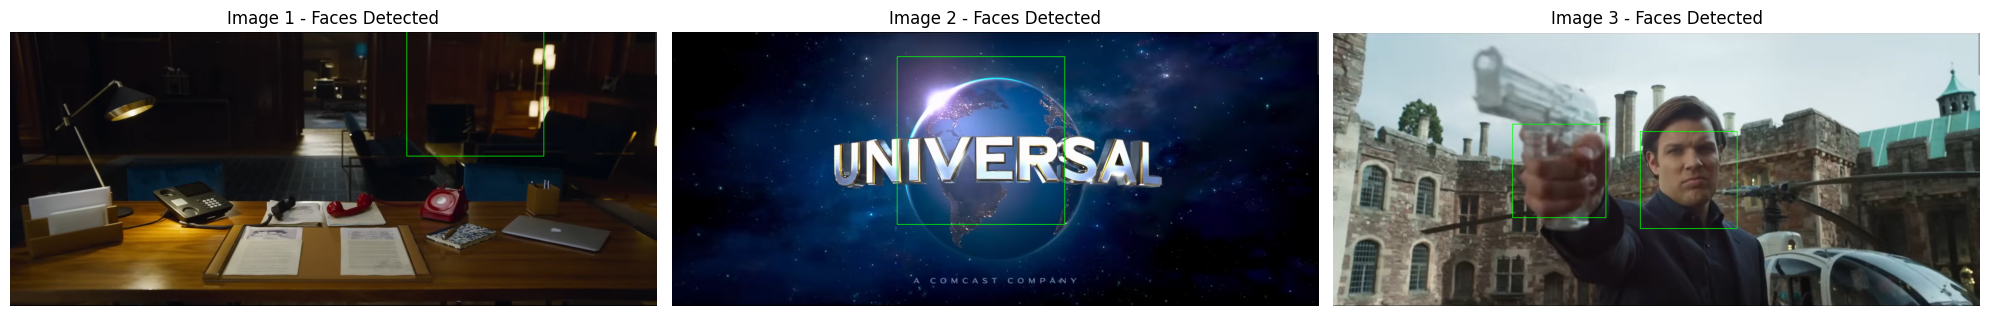

In [13]:
# List of image file paths
image_paths = [
    'images/johnny-english-capture-3.png',
    'images/johnny-english-capture-4.png',
    'images/johnny-english-capture-5.png'
]

# Load, process, and store results for all images
processed_images = []
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=min_detection_confidence) as face_detection:
    for path in image_paths:
        # Load each image
        image = cv.imread(path)
        # Detect faces and draw bounding boxes
        processed_image = utils.detect_faces_mediapipe(image.copy(), face_detection)
        # Convert to RGB for Matplotlib and append to results
        processed_images.append(cv.cvtColor(processed_image, cv.COLOR_BGR2RGB))

# Plot the images side by side
plt.rcParams['figure.figsize'] = (15.0, 10.0)  # Adjust figure size for 5 images
fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # Create subplots for 5 images

for i, ax in enumerate(axs):
    ax.imshow(processed_images[i])  # Display each processed image
    ax.axis('off')  # Hide axes
    ax.set_title(f"Image {i+1} - Faces Detected")

plt.tight_layout()
plt.show()

Comme vous pouvez le voir, des visages sont parfois détectés dans des zones incorrectes, telles que des zones vides, sur le globe terrestre ou même sur une arme présente dans l'image. Cela se produit même lorsque nous utilisons un seuil de confiance élevé, fixé à 90 %.

Ces limitations nous ont conduit à envisager l'exploration d'un autre modèle capable d'offrir de meilleurs résultats et d'éviter ces erreurs de fausse détection.

### Initialisation de YuNet

Pour surmonter les limitations observées avec le modèle précédent, nous nous sommes tournés vers [YuNet](https://github.com/ShiqiYu/libfacedetection), un modèle de détection de visages optimisé pour la précision et la vitesse. L'avantage de ce modèle réside dans sa légerté et son efficacité dans des tâches de détection en temps réel, qui était notre ambition de départ.

In [22]:
# Initialize YuNet Face Detector
model_path = 'models/face_detection_yunet_2023mar.onnx'  # Path to your YuNet ONNX model
face_detector = cv.FaceDetectorYN_create(
    model=model_path,
    config="",
    #input_size=(300, 300),
    input_size= (640, 640),
    #score_threshold=0.5,
    score_threshold=0.3,
    #nms_threshold=0.3,
    nms_threshold=0.4,
    top_k=5000
)

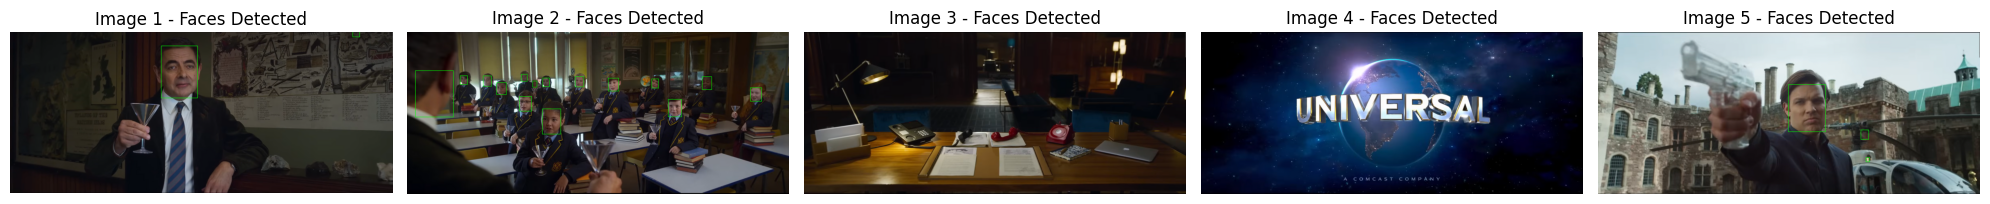

In [23]:
image_paths = [
    'images/johnny-english-capture-1.png',
    'images/johnny-english-capture-2.png',
    'images/johnny-english-capture-3.png',
    'images/johnny-english-capture-4.png',
    'images/johnny-english-capture-5.png'
]

# Process each image
processed_images = []
for path in image_paths:
    # Load the image
    image = cv.imread(path)
    # Detect faces and draw bounding boxes
    processed_image = utils.detect_faces_yunet(image.copy(), face_detector)
    # Convert BGR to RGB for Matplotlib and store
    processed_images.append(cv.cvtColor(processed_image, cv.COLOR_BGR2RGB))

# Plot the images side by side
plt.rcParams['figure.figsize'] = (20.0, 10.0)  # Adjust figure size for 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # Create subplots for 5 images

for i, ax in enumerate(axs):
    ax.imshow(processed_images[i])  # Display each processed image
    ax.axis('off')  # Hide axes
    ax.set_title(f"Image {i+1} - Faces Detected")

plt.tight_layout()
plt.show()

Comme visible sur les images, YuNet offre de meilleurs résultats. Nous n'obtenons plus de faux négatif, et les visages plus difficiles à repérer sont tout de même détectés. 

Le code suivant nous permet de comparer la sortie de nos deux modèles sur les mêmes images.

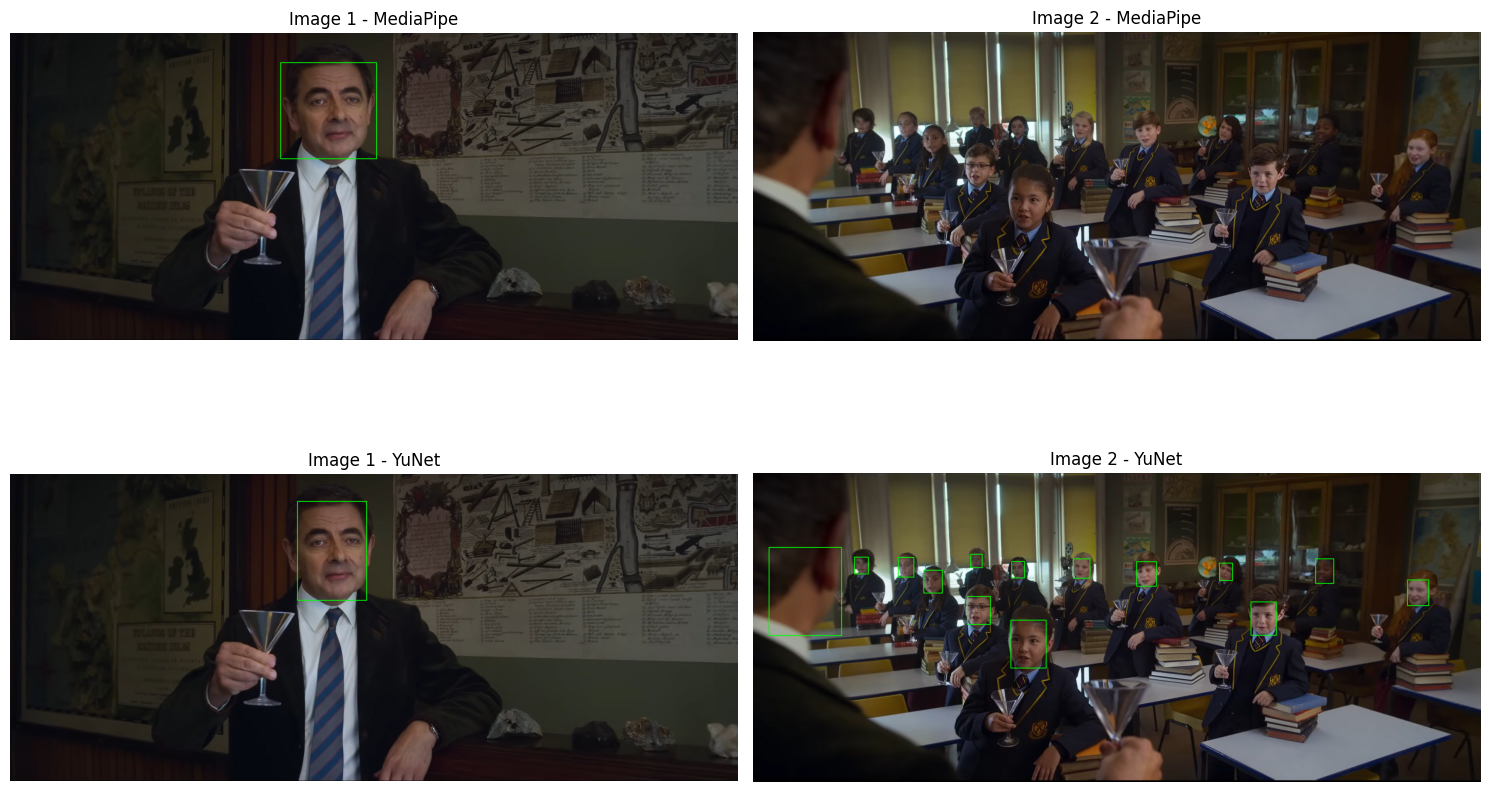

In [24]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection

# Initialize YuNet Face Detector
model_path = 'models/face_detection_yunet_2023mar.onnx'  # Path to your YuNet ONNX model
yunet_detector = cv.FaceDetectorYN_create(
    model=model_path,
    config="",
    input_size=(300, 300),  # Initial input size
    score_threshold=0.5,
    nms_threshold=0.3,
    top_k=5000
)

# Load the two images
image1 = cv.imread('images/johnny-english-capture-1.png')
image2 = cv.imread('images/johnny-english-capture-2.png')

# Perform face detection using both models
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=min_detection_confidence) as face_detection:
    # MediaPipe Results
    image1_mediapipe = utils.detect_faces_mediapipe(image1.copy(), face_detection)
    image2_mediapipe = utils.detect_faces_mediapipe(image2.copy(), face_detection)

# YuNet Results
image1_yunet = utils.detect_faces_yunet(image1.copy(), yunet_detector)
image2_yunet = utils.detect_faces_yunet(image2.copy(), yunet_detector)

# Convert images to RGB for Matplotlib
image1_mediapipe_rgb = cv.cvtColor(image1_mediapipe, cv.COLOR_BGR2RGB)
image2_mediapipe_rgb = cv.cvtColor(image2_mediapipe, cv.COLOR_BGR2RGB)
image1_yunet_rgb = cv.cvtColor(image1_yunet, cv.COLOR_BGR2RGB)
image2_yunet_rgb = cv.cvtColor(image2_yunet, cv.COLOR_BGR2RGB)

# Plot results for comparison
plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, axs = plt.subplots(2, 2)

# Display MediaPipe results
axs[0, 0].imshow(image1_mediapipe_rgb)
axs[0, 0].axis('off')
axs[0, 0].set_title("Image 1 - MediaPipe")

axs[0, 1].imshow(image2_mediapipe_rgb)
axs[0, 1].axis('off')
axs[0, 1].set_title("Image 2 - MediaPipe")

# Display YuNet results
axs[1, 0].imshow(image1_yunet_rgb)
axs[1, 0].axis('off')
axs[1, 0].set_title("Image 1 - YuNet")

axs[1, 1].imshow(image2_yunet_rgb)
axs[1, 1].axis('off')
axs[1, 1].set_title("Image 2 - YuNet")

plt.tight_layout()
plt.show()


## Character recognition

Plutôt que de fine-tuner un modèle de reconnaissance pour identifier des personnages, ce qui serait coûteux en temps et en ressources, nous avons choisi une méthode plus simple et extensible. 

Notre approche consiste à utiliser un modèle pré-entraîné pour extraire les embeddings faciaux, qui sont des représentations numériques des visages. Une fois ces embeddings extraits, nous comparons directement les embeddings des visages détectés avec ceux des visages connus en utilisant une métrique de distance comme la distance euclidienne.

À notre avantage, la bibliothèque Dlib met à disposition des outils pour réaliser ces tâches rapidement.

Le module *utils* contient l'implémentation des fonctions pour extraire, récupérer, charger les embeddings des images présentes sur une image. Nous vous invitons à consulter le fichier pour comprendre la démarche. 

In [25]:
known_face_encodings, known_face_names = utils.load_embeddings('embeddings/face_embeddings_multiple.pkl')

Successfully loaded 9 embeddings from embeddings/face_embeddings_multiple.pkl


In [26]:
known_face_encodings

[array([-1.00824006e-01,  9.71191451e-02,  9.86282602e-02, -2.91456878e-02,
        -4.03978489e-02,  1.10149883e-01,  1.72984805e-02, -1.14352964e-01,
         9.22664925e-02,  3.51157435e-03,  2.33389392e-01,  4.71938848e-02,
        -3.25349689e-01, -2.48499680e-02,  5.68902716e-02,  9.77530554e-02,
        -1.18988410e-01, -1.22066632e-01, -1.69188812e-01, -3.82877626e-02,
        -7.78535381e-03,  6.78626522e-02,  1.94972698e-02,  2.25120578e-02,
        -1.72842100e-01, -2.57180035e-01, -7.21551627e-02, -1.14061497e-02,
         1.57590322e-02, -2.08174810e-01,  8.83726869e-03,  4.57920786e-03,
        -1.49457961e-01,  1.87748224e-02, -2.74600759e-02,  1.24289803e-02,
        -6.11610822e-02, -1.34269223e-01,  2.47711778e-01,  9.21554938e-02,
        -1.60732910e-01,  3.39646749e-02,  2.69815810e-02,  3.11040938e-01,
         2.44447619e-01, -5.44647239e-02,  1.87461320e-02, -2.09922045e-02,
         1.42244920e-01, -3.42277676e-01,  3.28692570e-02,  1.22355066e-01,
         1.2

In [27]:
known_face_names

['Agent Bough',
 'Agent Bough',
 'Agent Bough',
 'Johnny English',
 'Johnny English',
 'Johnny English',
 'Johnny English',
 'Ophelia',
 'Primo Ministro']

Maintenant que les embeddings enregistrés dans le fichier pickle (visages connus) sont chargés, nous pouvons appliquer la reconnaissance de visage sur nos images/videos.

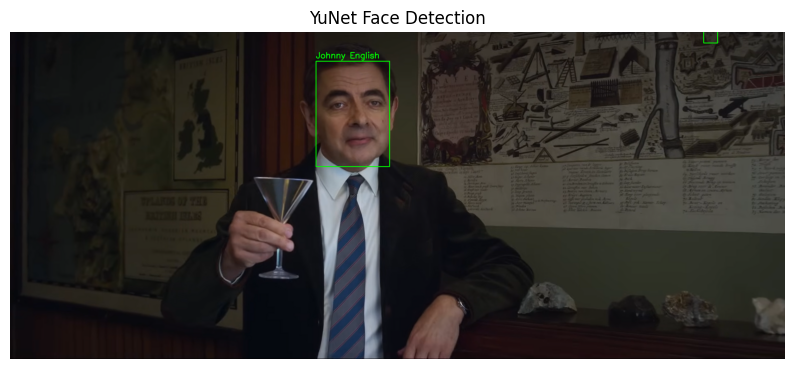

In [28]:
img = utils.detect_characters_yunet(image1.copy(), face_detector, known_face_encodings, known_face_names)

# Convert frame to RGB for Matplotlib
frame_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Display the image with Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title("YuNet Face Detection")
plt.show()

Amusons-nous avec d'autres frames. 

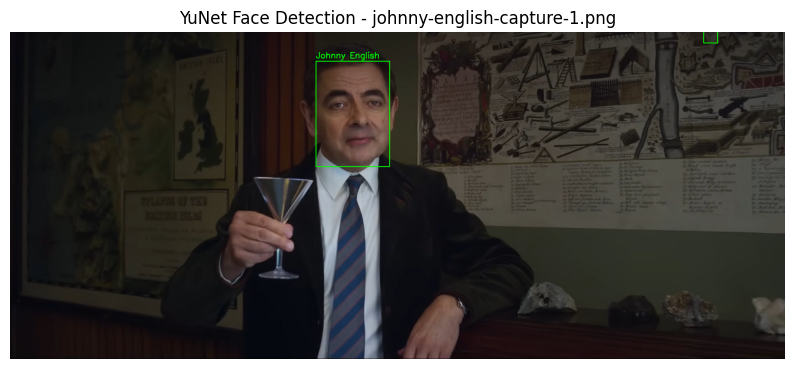

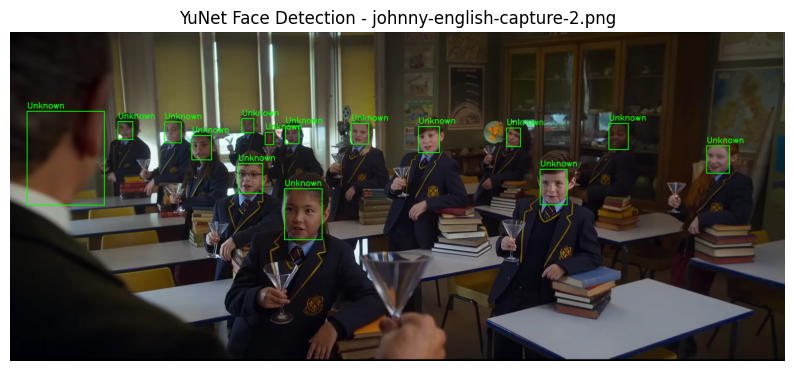

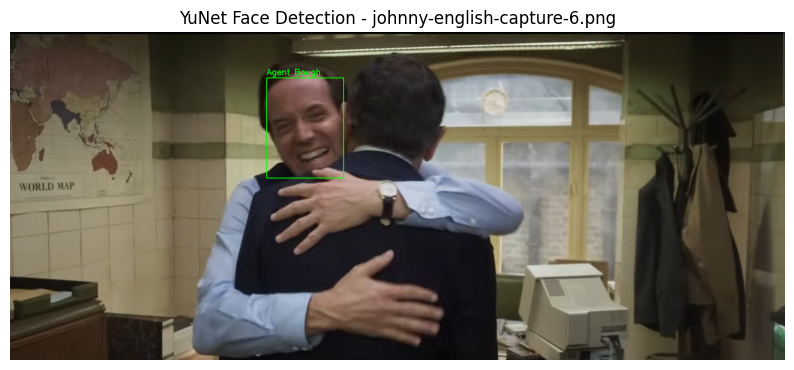

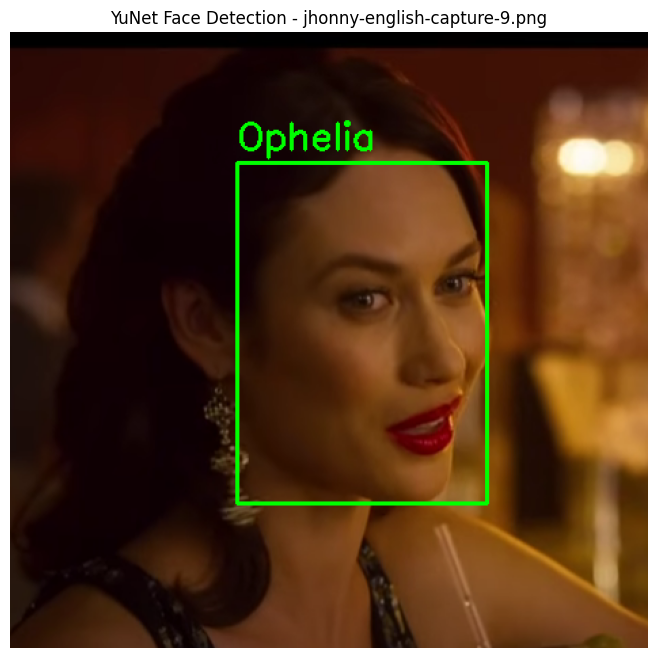

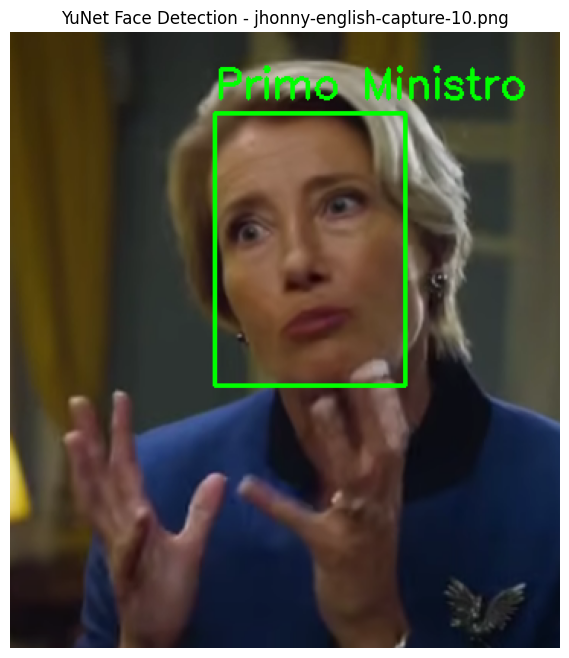

In [31]:
image_paths = [
    'images/johnny-english-capture-1.png',
    'images/johnny-english-capture-2.png',
    'images/johnny-english-capture-6.png',
    'images/jhonny-english-capture-9.png',
    'images/jhonny-english-capture-10.png',

]

for img_path in image_paths:
        # Load the image
        image = cv.imread(img_path)
        # Perform face detection using YuNet
        img = utils.detect_characters_yunet(image.copy(), face_detector, known_face_encodings, known_face_names)
        # Convert the image to RGB for Matplotlib
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Display the image with Matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"YuNet Face Detection - {img_path.split('/')[-1]}")  # Title with image filename
        plt.show()


Notre modèle fonctionne globalement bien pour détecter et reconnaître les visages. Cependant, sur certaines images (frames), il rencontre encore des difficultés à identifier correctement les personnages. Ces erreurs sont souvent dues à des conditions défavorables, telles que un mauvais éclairage ou un angle difficile. La faible résolution des vidéos joue également.

# Résultats

Bien que nous voulions appliquer le traitement en temps réel, nous nous sommes rendu compte que le calcul des embedding prenait trop de temps et ne permettait pas de produire un résultat fluide. Nous avons donc appliqué le traitement sur les vidéos pour produire des vidéos en sorties que vous pouvez visionner, présent dans le dossier videos.